In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rasterio
import torch
import matplotlib.pyplot as plt
import os
from pathlib import Path
from tqdm.auto import tqdm

from urbanlc.downloader import LandsatTM, LandsatOLITIRS
from urbanlc.model import LCClassifier
from urbanlc.analyze import plot_land_cover, plot_landsat
from urbanlc import export_geotiff

## Download and Analyze data from TM sensor

In [3]:
# ensure that the study area is larger than 224 x 224 (that's the minimum input size for the model)
# basically, set radius >= 1120 (meters, approximate number)
coordinate = [2.3522, 48.8566]
years = [1989, 1990]

downloader = LandsatTM.initialize(n_landsat=5, root="./demo_data")
downloader.download_images(coordinate, radius=1200, years=years)

[2023-11-28 14:07:59,052][INFO|landsat_downloader.py:183] > Dataset: landsat5
[2023-11-28 14:07:59,052][INFO|landsat_downloader.py:184] > Years : [1989, 1990]
[2023-11-28 14:07:59,053][INFO|landsat_downloader.py:185] > Bounding boxes : [2.335921385172166, 48.84580550979554, 2.368531089273308, 48.867398639141804]
[2023-11-28 14:07:59,053][INFO|landsat_downloader.py:186] > Months for calculating median: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[2023-11-28 14:08:01,270][INFO|landsat_downloader.py:224] > Retrieved image for year 1989 from landsat5
[2023-11-28 14:08:03,448][INFO|landsat_downloader.py:224] > Retrieved image for year 1990 from landsat5
[2023-11-28 14:08:03,449][INFO|base.py:268] > Downloading image patches...
[2023-11-28 14:08:07,320][INFO|base.py:287] > Downloaded and saved at ./demo_data/cache/landsat5_1989_0.tif
[2023-11-28 14:08:07,628][INFO|base.py:215] > Successfully merge patches, saved at ./demo_data/landsat5_1989.tif
[2023-11-28 14:08:07,630][INFO|base.py:219] > Delet

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


[2023-11-28 14:08:11,372][INFO|base.py:287] > Downloaded and saved at ./demo_data/cache/landsat5_1990_0.tif
[2023-11-28 14:08:11,434][INFO|base.py:215] > Successfully merge patches, saved at ./demo_data/landsat5_1990.tif
[2023-11-28 14:08:11,436][INFO|base.py:219] > Deleted all files in ./demo_data/cache


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [18]:
model = LCClassifier.from_pretrained(sensor="TM", pretrained_model_name_or_path="TM_resnet50")

if torch.cuda.is_available():
    model.to("cuda")

print(model.device)

Initialize using pretrained weights
{'index_swir': 4, 'index_nir': 3}
{'index_nir': 3, 'index_red': 2}
{'index_a': -2, 'index_b': -1}
Use legends from ESA2021 (11 classes) as default
cuda


In [19]:
type(model.transform_pipeline)

urbanlc.model.pipeline_transforms.TMTransformer

In [20]:
img_paths = ["./demo_data/landsat5_1989.tif", "./demo_data/landsat5_1990.tif"]
output_paths = ["./demo_output/landsat5_1989.tif", "./demo_output/landsat5_1990.tif"]

with torch.no_grad():
    for img_path, save_path in tqdm(zip(img_paths, output_paths), total=len(img_paths)):
        preds = model.infer(img_path, convert_numpy=True) # predictions are in 0 to N-1 classes
        land_cover = model.denormalize_class(preds) # convert labels to 10, 20, ..., 100 (ESA Worldcover)

        # save prediction
        os.makedirs(Path(save_path).parent, exist_ok=True)
        output_meta = rasterio.open(img_path).meta
        output_meta["dtype"] = "uint8"
        output_meta["nodata"] = "0.0"
        params = {
            "img": land_cover,
            "save_path": save_path,
            "output_meta": output_meta,
            "compress": "PACKBITS",
        }
        export_geotiff(**params)

  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([4, 7, 224, 224])
[0.08163042661356694, 0.10085783731931074, 0.10701118915780652, 0.20055640287459503, 0.1701256492465244, 0.12407282351539259, 291.8235398823627, 0.0, 0.0, 0.0]
[0.05398084773803982, 0.05849992704495288, 0.06925856941611415, 0.08748855275238117, 0.08646376806562776, 0.07575478301131, 48.37941596949521, 1.0, 1.0, 1.0]
Sequential(
  (0): AppendNDBI(p=1, p_batch=1.0, same_on_batch=False, index_a=4, index_b=3)
  (1): AppendNDVI(p=1, p_batch=1.0, same_on_batch=False, index_a=3, index_b=2)
  (2): AppendBUI(p=1, p_batch=1.0, same_on_batch=False, index_a=-2, index_b=-1)
  (3): Normalize(mean=[0.08163042661356694, 0.10085783731931074, 0.10701118915780652, 0.20055640287459503, 0.1701256492465244, 0.12407282351539259, 291.8235398823627, 0.0, 0.0, 0.0], std=[0.05398084773803982, 0.05849992704495288, 0.06925856941611415, 0.08748855275238117, 0.08646376806562776, 0.07575478301131, 48.37941596949521, 1.0, 1.0, 1.0])
)
{'index_swir': 4, 'index_nir': 3}
{'index_nir': 3, 'ind

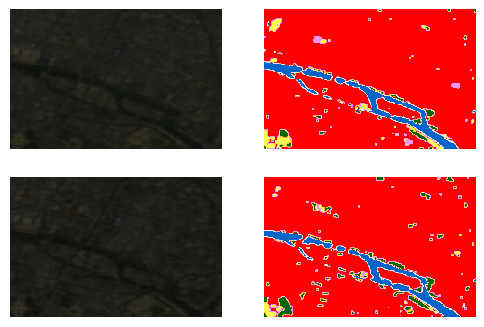

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(6, 4))

img = rasterio.open(img_paths[0]).read()
plot_landsat(img, dataset="landsat5", ax=ax[0,0])

img = rasterio.open(img_paths[1]).read()
plot_landsat(img, dataset="landsat5", ax=ax[1,0])

img = rasterio.open(output_paths[0]).read()
plot_land_cover(img, ax=ax[0,1])

img = rasterio.open(output_paths[1]).read()
plot_land_cover(img, ax=ax[1,1])

## Landsat 7-8 (OLI-TIRS)

We can do similar things using data from Landsat7-8. Don't forget that Landsat-7 uses TM sensor, so we need to use ```LandsatTM``` for it.

In [22]:
# ensure that the study area is larger than 224 x 224 (that's the minimum input size for the model)
# basically, set radius >= 1120 (meters, approximate number)
coordinate = [2.3522, 48.8566]
years = [2020, 2021]

downloader = LandsatOLITIRS.initialize(n_landsat=8, root="./demo_data/landsat8")
downloader.download_images(coordinate, radius=1200, years=years)

[2023-11-28 14:19:09,974][INFO|landsat_downloader.py:183] > Dataset: landsat8
[2023-11-28 14:19:09,975][INFO|landsat_downloader.py:184] > Years : [2020, 2021]
[2023-11-28 14:19:09,975][INFO|landsat_downloader.py:185] > Bounding boxes : [2.335921385172166, 48.84580550979554, 2.368531089273308, 48.867398639141804]
[2023-11-28 14:19:09,976][INFO|landsat_downloader.py:186] > Months for calculating median: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[2023-11-28 14:19:12,227][INFO|landsat_downloader.py:224] > Retrieved image for year 2020 from landsat8
[2023-11-28 14:19:14,623][INFO|landsat_downloader.py:224] > Retrieved image for year 2021 from landsat8
[2023-11-28 14:19:14,624][INFO|base.py:268] > Downloading image patches...
[2023-11-28 14:19:18,777][INFO|base.py:287] > Downloaded and saved at ./demo_data/landsat8/cache/landsat8_2020_0.tif
[2023-11-28 14:19:18,838][INFO|base.py:215] > Successfully merge patches, saved at ./demo_data/landsat8/landsat8_2020.tif
[2023-11-28 14:19:18,840][INFO|ba

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


[2023-11-28 14:19:23,035][INFO|base.py:287] > Downloaded and saved at ./demo_data/landsat8/cache/landsat8_2021_0.tif
[2023-11-28 14:19:23,099][INFO|base.py:215] > Successfully merge patches, saved at ./demo_data/landsat8/landsat8_2021.tif
[2023-11-28 14:19:23,100][INFO|base.py:219] > Deleted all files in ./demo_data/landsat8/cache


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [23]:
model = LCClassifier.from_pretrained(sensor="OLITIRS", pretrained_model_name_or_path="OLITIRS_resnet50")

if torch.cuda.is_available():
    model.to("cuda")

print(model.device)

Initialize using pretrained weights
Use legends from ESA2021 (11 classes) as default
cuda


In [24]:
img_paths = ["./demo_data/landsat8/landsat8_2020.tif", "./demo_data/landsat8/landsat8_2021.tif"]
output_paths = ["./demo_output/landsat8/landsat8_2020.tif", "./demo_output/landsat8/landsat8_2021.tif"]

with torch.no_grad():
    for img_path, save_path in tqdm(zip(img_paths, output_paths), total=len(img_paths)):
        preds = model.infer(img_path, convert_numpy=True) # predictions are in 0 to N-1 classes
        land_cover = model.denormalize_class(preds) # convert labels to 10, 20, ..., 100 (ESA Worldcover)

        # save prediction
        os.makedirs(Path(save_path).parent, exist_ok=True)
        output_meta = rasterio.open(img_path).meta
        output_meta["dtype"] = "uint8"
        output_meta["nodata"] = "0.0"
        params = {
            "img": land_cover,
            "save_path": save_path,
            "output_meta": output_meta,
            "compress": "PACKBITS",
        }
        export_geotiff(**params)

  0%|          | 0/2 [00:00<?, ?it/s]

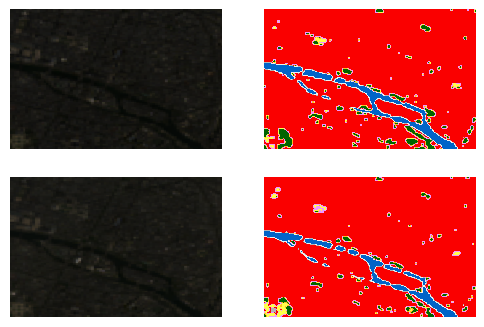

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(6, 4))

img = rasterio.open(img_paths[0]).read()
plot_landsat(img, dataset="landsat8", ax=ax[0,0])

img = rasterio.open(img_paths[1]).read()
plot_landsat(img, dataset="landsat8", ax=ax[1,0])

img = rasterio.open(output_paths[0]).read()
plot_land_cover(img, ax=ax[0,1])

img = rasterio.open(output_paths[1]).read()
plot_land_cover(img, ax=ax[1,1])